In [1]:
import os
import fitparse
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# For fast Speed
allowed_fields = ['timestamp', 'position_lat', 'position_long', 'altitude']
required_fields = ['timestamp', 'position_lat', 'position_long', 'altitude']

UTC = pytz.UTC
CST = pytz.timezone('US/Central')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 100)

In [3]:
file = '/Users/chord/Downloads/fitComputer/2018-05-29-08-17-01.fit'

In [4]:
fitfile = fitparse.FitFile(file, data_processor=fitparse.StandardUnitsDataProcessor())

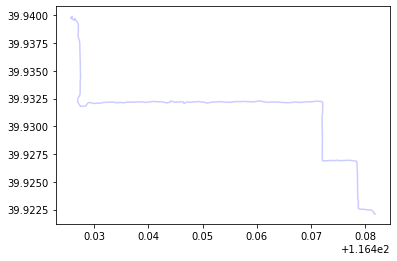

In [5]:
        messages = fitfile.messages
        data = []
        for m in messages:
            skip = False
            if not hasattr(m, 'fields'):
                continue
            fields = m.fields
            # check for important data types
            mdata = {}
            for field in fields:
                if field.name in allowed_fields:
                    if field.name == 'timestamp':
                        mdata[field.name] = UTC.localize(field.value).astimezone(CST)
                    else:
                        mdata[field.name] = field.value
            for rf in required_fields:
                if rf not in mdata:
                    skip = True
            if not skip:
                data.append(mdata)

        try:
            lat_data = pd.DataFrame(data)["position_lat"].astype(str).replace("None", np.nan).astype(float)
            long_data = pd.DataFrame(data)["position_long"].astype(str).replace("None", np.nan).astype(float)
            plt.plot(long_data, lat_data, 'b', alpha=0.2)
        except KeyError:
            print("error")

In [6]:
coords = pd.DataFrame(data)

In [7]:
coords_shift = coords.shift()

In [8]:

from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000


In [9]:
combine_coords = pd.DataFrame({'lon1':coords['position_long'],'lat1':coords['position_lat'],'lon2':coords_shift['position_long'],'lat2':coords_shift['position_lat']})

In [10]:
combine_coords['distance'] = combine_coords.apply(lambda x: haversine(x[0],x[1],x[2],x[3]),axis=1)

In [11]:
combine_coords.head()

,lon1,lat1,lon2,lat2,distance
0,116.425882,39.939887,NaN,NaN,NaN
1,116.425928,39.939922,116.425882,39.939887,5.539068
2,116.425910,39.939904,116.425928,39.939922,2.480915
3,116.425887,39.939883,116.425910,39.939904,3.103705
4,116.425805,39.939827,116.425887,39.939883,9.344124


In [12]:
coords[combine_coords['distance'] < 3].head()

,timestamp,position_lat,position_long,altitude
2,2018-05-29 07:17:03-05:00,39.939904,116.425910,2684
8,2018-05-29 07:17:09-05:00,39.939767,116.425742,2688
9,2018-05-29 07:17:10-05:00,39.939762,116.425753,2688
11,2018-05-29 07:17:12-05:00,39.939790,116.425820,2688
13,2018-05-29 07:17:14-05:00,39.939802,116.425875,2687


In [13]:
coords[combine_coords['distance'] < 3].reset_index(drop=True).head()

,timestamp,position_lat,position_long,altitude
0,2018-05-29 07:17:03-05:00,39.939904,116.425910,2684
1,2018-05-29 07:17:09-05:00,39.939767,116.425742,2688
2,2018-05-29 07:17:10-05:00,39.939762,116.425753,2688
3,2018-05-29 07:17:12-05:00,39.939790,116.425820,2688
4,2018-05-29 07:17:14-05:00,39.939802,116.425875,2687
